# Tesseract

Tesseract is an open source text recognition (OCR) Engine, available under the Apache 2.0 license.

[languages supported](https://tesseract-ocr.github.io/tessdoc/Data-Files-in-different-versions.html)


# Pytesseract

Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and "read" the text embedded in images in formats such as including jpeg, png, gif, bmp, tiff, and others

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import pathlib
import pandas as pd

from PIL import Image

TEST_DIR = pathlib.Path("./data/forms")
test_form = "./data/forms/example2.png"
checkbox_template_path = "./data/screenshots/checkbox.png"

## Reading W-4 IRS Forms

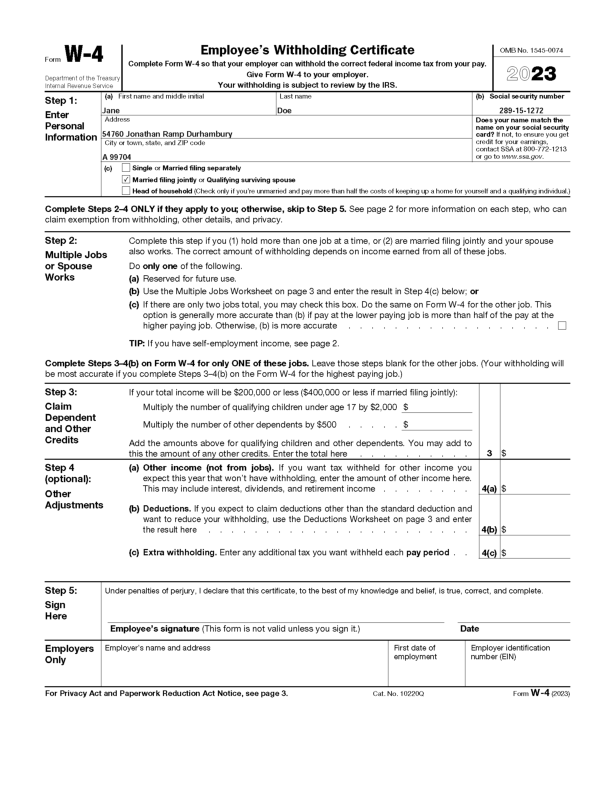

In [16]:
img_orig = cv2.imread(test_form)
img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img, cmap="gray")

# Tesseract Read All Text

- gathers all text
- gets all information
- hard to get information from this format
- reads left to right

In [4]:
# Simple image to string
print(pytesseract.image_to_string(img))

conn W-4 Employee’s Withholding Certificate OMB No. 1545-0074

Complete Form W-4 so that your employer can withhold the correct federal income tax from your pay.
Department of the Treasury Give Form W-4 to your employer. 2 @) 23

Internal Revenue Service Your withholding is subject to review by the IRS.
Step 1: (a) First name and middle initial Last name (b) Social security number
Jane Doe 289-15-1272
Enter ‘Address Does your name match the
Personal name on your social security
Information [54760 Jonathan Ramp Durhambury card? If not, to ensure you get
City or town, state, and ZIP code credit for your earnings,
contact SSA at 800-772-1213
A 99704 or go to www.ssa.gov.
(ce) Single or Married filing separately
¥| Maniied filing jointly or Qualifying surviving spouse
Head of household (Check only if you’re unmarried and pay more than half the costs of keeping up a home for yourself and a qualifying individual.)

Complete Steps 2-4 ONLY if they apply to you; otherwise, skip to Step 5. See 

# Lets Use Templating Capabilities

- pick up the ROIS (can do this in PDF view coordinates)
- grab them for each location

In [5]:
rois = [
    (261, 233, 759, 299), # Example bounding coordinates x0, y0, x1, y1
    (757, 233, 1314, 299),
    (262, 300, 1316, 365),
    (261, 368, 1319, 433)
]

checkbox_rois = [
    (314, 435, 345, 463),
    (314, 466, 345, 496),
    (314, 496, 343, 529)
]

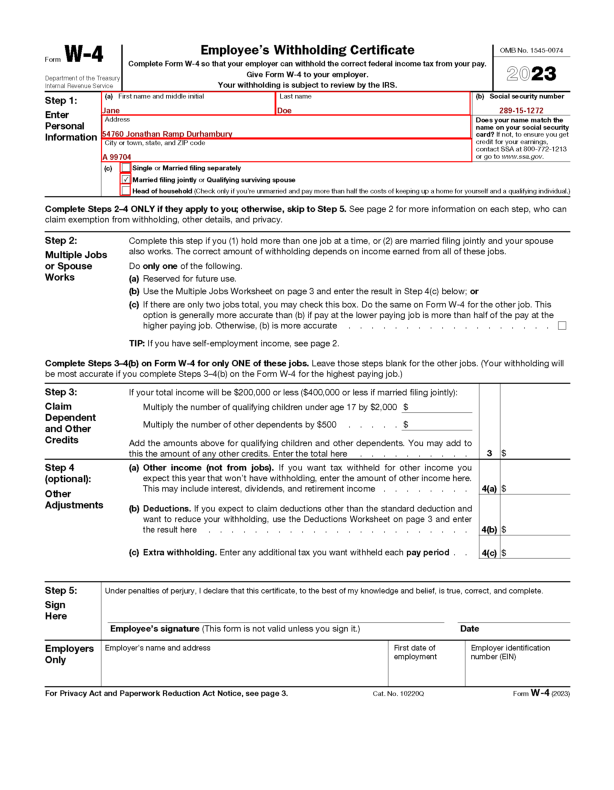

In [17]:
img_copy = img_orig.copy()

# Draw rectangles on the image
for (x0, y0, x1, y1) in rois+checkbox_rois:
    cv2.rectangle(img_copy, (x0, y0), (x1, y1), (255, 0, 0), 2)
    

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img_copy)

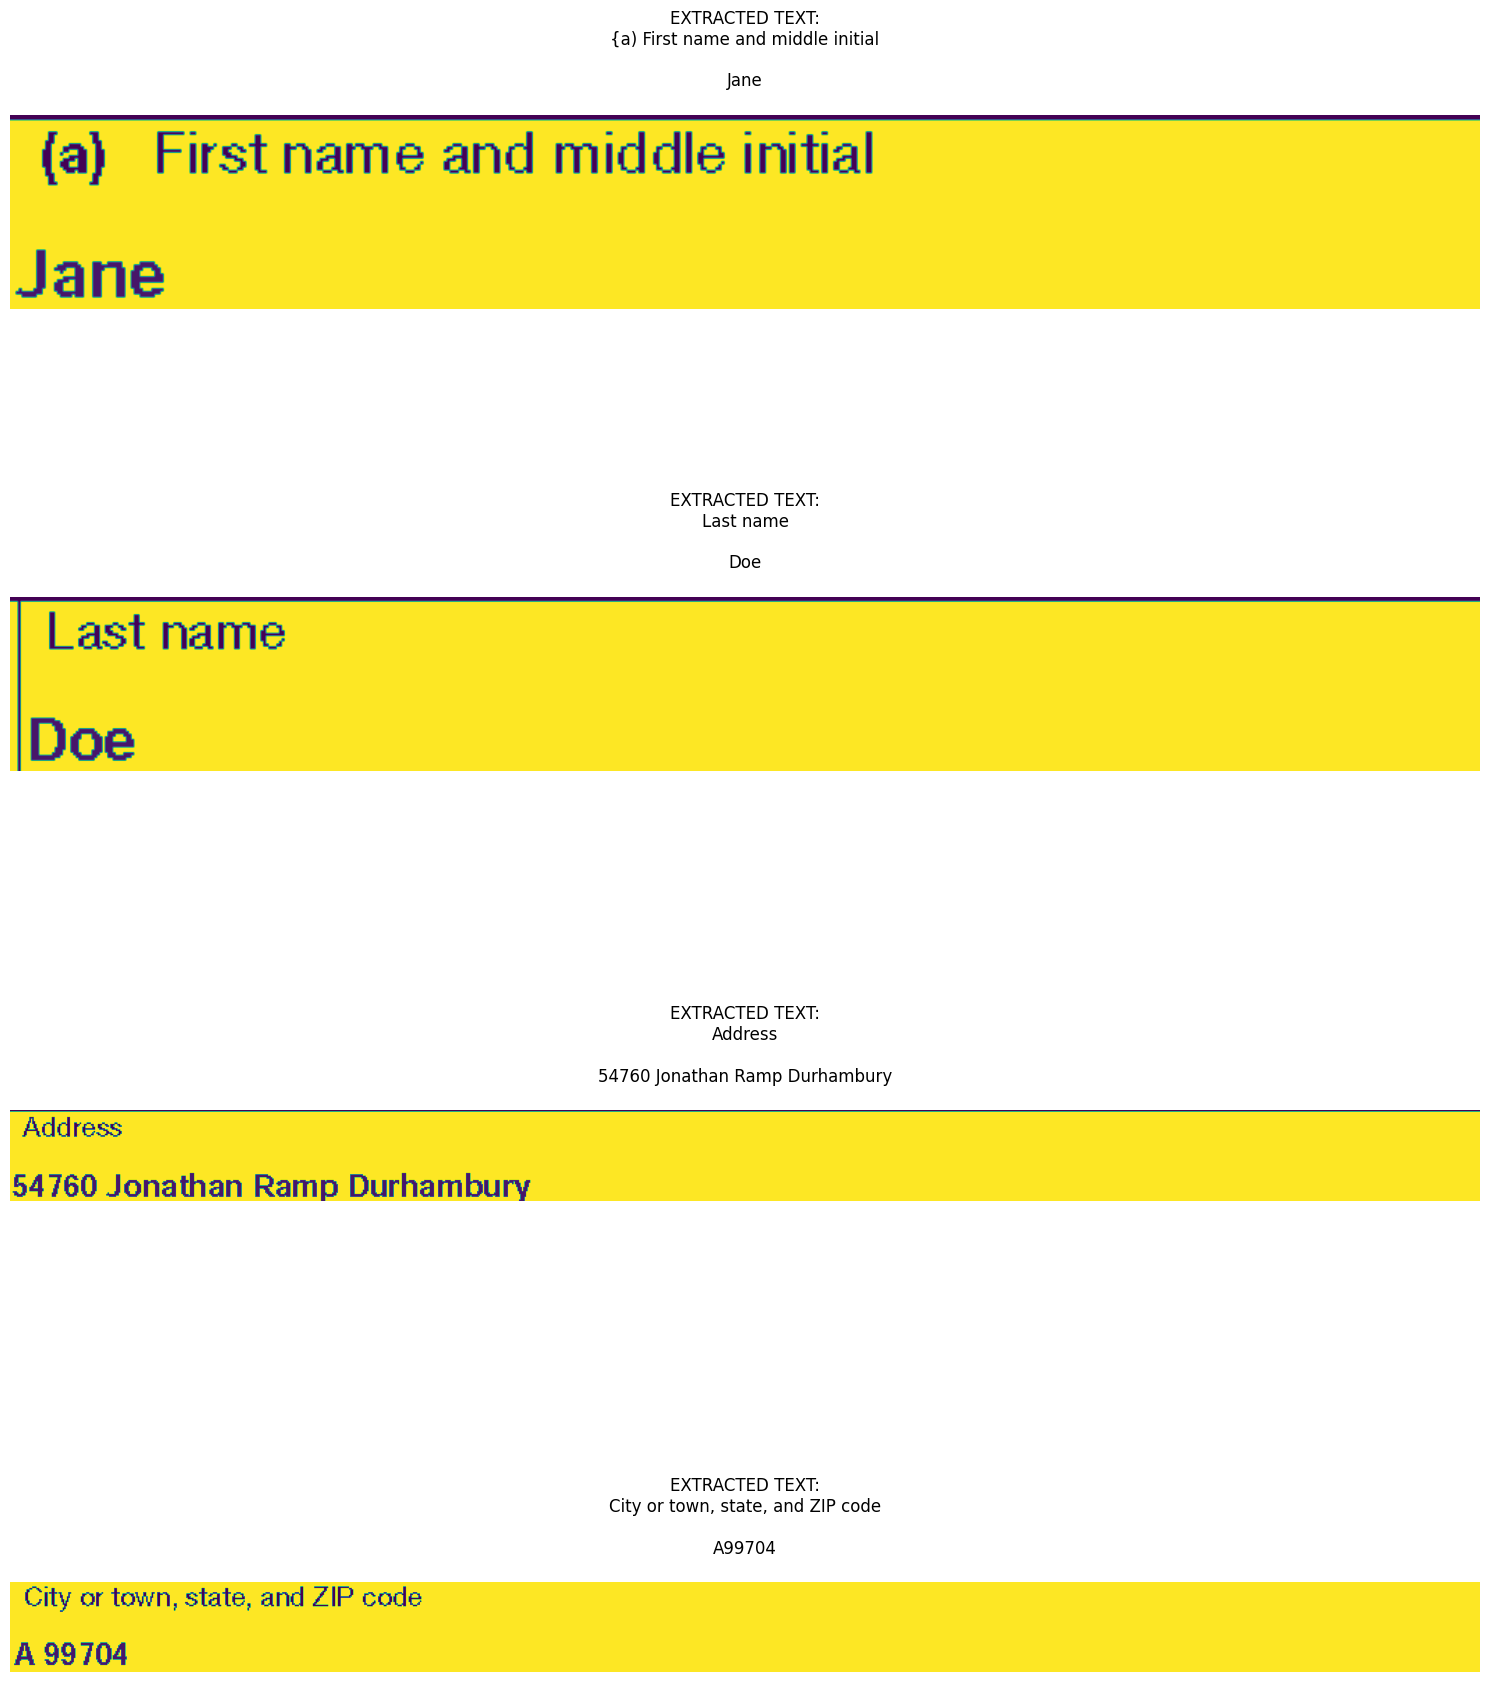

In [13]:
# Create a new figure and subplots
fig, axs = plt.subplots(len(rois), 1, figsize=(15, 20))  # +1 for the original image subplot

# Iterate over ROIs and display them in subplots
for i, roi in enumerate(rois):
    x0, y0, x1, y1 = roi
    roi_image = img[y0:y1, x0:x1]
    text = pytesseract.image_to_string(roi_image)
    axs[i].imshow(roi_image)
    axs[i].axis('off')
    axs[i].set_title(f'EXTRACTED TEXT:\n{text}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

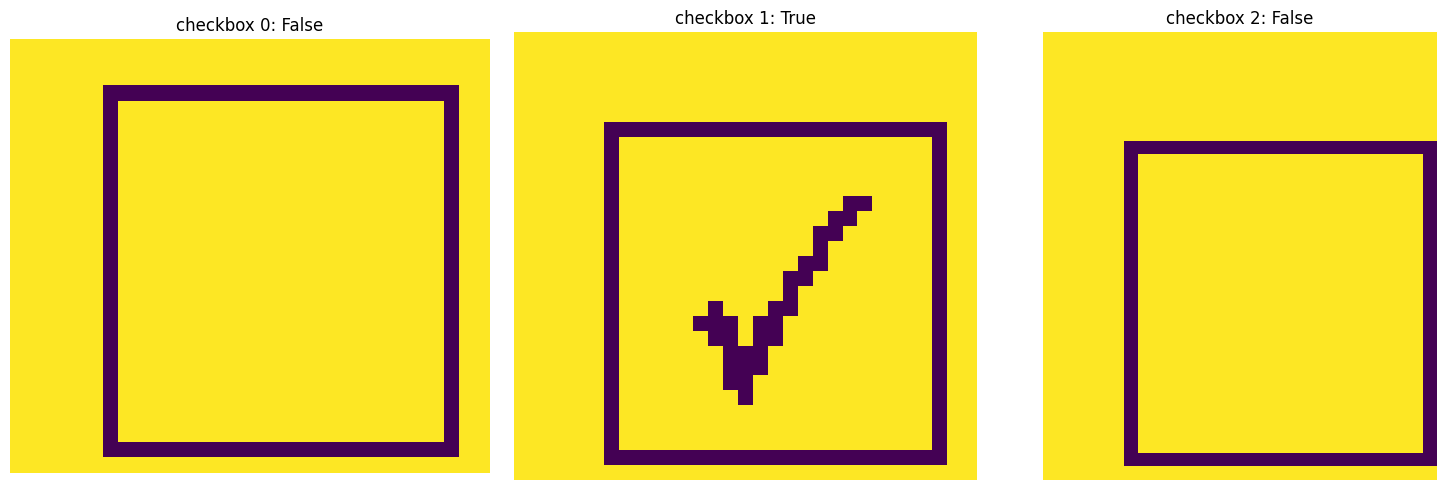

In [8]:
# Create a new figure and subplots
fig, axs = plt.subplots(1, len(checkbox_rois), figsize=(15, 5))  # +1 for the original image subplot

# Iterate over ROIs and display them in subplots
for i, roi in enumerate(checkbox_rois):
    x0, y0, x1, y1 = roi
    roi_image = img[y0:y1, x0:x1]
    threshold_score = np.count_nonzero(roi_image == 0)
    axs[i].imshow(roi_image)
    axs[i].axis('off')
    is_ticked = True if threshold_score > 100 else False
    axs[i].set_title(f'checkbox {i}: {is_ticked}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Run A Pipeline Over Multiple Documents

In [9]:
def pipeline(pdf_path):
    img = cv2.imread(pdf_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    output_dict = {}
    
    roi_keys = ["first_name", "last_name",  "address", "postcode"]
    for i, (key, roi) in enumerate(zip(roi_keys, rois)):
        x0, y0, x1, y1 = roi
        roi_image = img[y0:y1, x0:x1]
        text = pytesseract.image_to_string(roi_image)
        output_dict[key] = text.split("\n")[-2]
        
    # Iterate over ROIs and display them in subplots
    checkbox_keys = ["single", "jointly", "head_of_household"]
    for i, (key, roi) in enumerate(zip(checkbox_keys, checkbox_rois)):
        x0, y0, x1, y1 = roi
        roi_image = img[y0:y1, x0:x1]
        threshold_score = np.count_nonzero(roi_image == 0)
        is_ticked = True if threshold_score > 100 else False
        output_dict[key] = is_ticked
    
    return output_dict

In [10]:
%%time

output_list = []
for file in TEST_DIR.iterdir():
    if file.suffix == ".png":
        print(file.name)
        output_list.append(pipeline(str(file)))
    
pd.DataFrame(output_list)

example1.png
example2.png
example3.png
CPU times: total: 469 ms
Wall time: 3.09 s


,first_name,last_name,address,postcode,single,jointly,head_of_household
0,John,Doe,"33483 Burton Spur Suite 524East Christina,",MO 94855,True,False,False
1,Jane,Doe,54760 Jonathan Ramp Durhambury,A99704,False,True,False
2,sam,Ghallager,54745 Ghunny Street Durhambury,ML 99704,False,True,False
